# Robyn Budget Allocator Demo

This notebook demonstrates how to use the Python implementation of Robyn's budget allocator.
It shows how to:
1. Load and prepare data
2. Configure the allocator
3. Run optimization scenarios
4. Analyze and visualize results

## Step 1: Load Exported R Data

In [1]:
## Step 1: Setup and Import
import sys
import os
import pandas as pd
import numpy as np
from typing import Dict, Any, Union, List
import matplotlib.pyplot as plt

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

# Import necessary Robyn classes
from robyn.data.entities.mmmdata import MMMData
from robyn.modeling.entities.modeloutputs import ModelOutputs
from robyn.data.entities.hyperparameters import Hyperparameters
from robyn.modeling.pareto.pareto_optimizer import ParetoResult
from robyn.visualization.allocator_plotter import AllocationPlotter
from utils.data_mapper import (
    load_data_from_json,
    import_input_collect,
    import_output_collect,
    import_output_models,
)

2024-11-20 17:29:39,647 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data from JSON exported from R
# raw_input_collect = load_data_from_json(
#     "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/dh_Pareto_InputCollect.json"
# )
# raw_output_collect = load_data_from_json(
#     "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/dh_Allocator_OutputCollect.json"
# )

raw_input_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/yj_InputCollect.json"
)
raw_output_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/yj_OutputCollect.json"
)

# raw_input_collect = load_data_from_json(
#     "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_InputCollect.json"
# )
# raw_output_collect = load_data_from_json(
#     "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_OutputCollect.json"
# )
# raw_output_models = load_data_from_json(
#     "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_OutputModels.json"
# )

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_collect = import_output_collect(raw_output_collect)
# python_model_outputs = import_output_models(raw_output_models)

# Extract individual components
mmm_data = r_input_collect["mmm_data"]
featurized_mmm_data = r_input_collect["featurized_mmm_data"]
holidays_data = r_input_collect["holidays_data"]
hyperparameters = r_input_collect["hyperparameters"]

# Print data summary
print(f"Data loaded successfully:")
print(
    f"- Data timeframe: {mmm_data.data[mmm_data.mmmdata_spec.date_var].min()} to {mmm_data.data[mmm_data.mmmdata_spec.date_var].max()}"
)
print(
    f"- Number of paid media channels: {len(mmm_data.mmmdata_spec.paid_media_spends)}"
)
print(f"- Channels: {mmm_data.mmmdata_spec.paid_media_spends}")

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00
Raw hyperparameters data: {'facebook_S_alphas': [0.5, 3], 'facebook_S_gammas': [0.3, 1], 'facebook_S_thetas': [0, 0.3], 'print_S_alphas': [0.5, 3], 'print_S_gammas': [0.3, 1], 'print_S_thetas': [0.1, 0.4], 'tv_S_alphas': [0.5, 3], 'tv_S_gammas': [0.3, 1], 'tv_S_thetas': [0.3, 0.8], 'search_S_alphas': [0.5, 3], 'search_S_gammas': [0.3, 1], 'search_S_thetas': [0, 0.3], 'ooh_S_alphas': [0.5, 3], 'ooh_S_gammas': [0.3, 1], 'ooh_S_thetas': [0.1, 0.4], 'newsletter_alphas': [0.5, 3], 'newsletter_gammas': [0.3, 1], 'newsletter_thetas': [0.1, 0.4], 'train_size': [0.5, 0.8]}
Data loaded successfully:
- Data timeframe: 2015-11-23 00:00:00 to 2019-11-11 00:00:00
- Number of paid media channels: 5
- Channels: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']


## Step 2: Set up Budget Allocator

Initialize the budget allocator with the selected model and data.

In [3]:
for solid in r_output_collect["pareto_result"].result_hyp_param["solID"]:
    print(f"Solution ID: {solid}")

Solution ID: 3_170_2
Solution ID: 3_172_5
Solution ID: 3_173_7
Solution ID: 3_173_8
Solution ID: 3_175_8
Solution ID: 3_177_2
Solution ID: 3_179_2
Solution ID: 3_180_3
Solution ID: 3_180_9
Solution ID: 3_182_4
Solution ID: 3_184_3
Solution ID: 3_185_9
Solution ID: 3_187_5
Solution ID: 3_189_3
Solution ID: 3_190_9
Solution ID: 3_193_3
Solution ID: 3_193_8
Solution ID: 3_194_6
Solution ID: 3_195_3
Solution ID: 3_195_8
Solution ID: 3_196_6
Solution ID: 3_197_5
Solution ID: 3_197_9
Solution ID: 3_198_1
Solution ID: 3_198_5
Solution ID: 3_200_9
Solution ID: 3_201_8
Solution ID: 3_202_1
Solution ID: 3_202_3
Solution ID: 3_202_5
Solution ID: 3_202_7
Solution ID: 3_204_3
Solution ID: 3_204_6
Solution ID: 3_204_9
Solution ID: 3_205_2
Solution ID: 3_205_4
Solution ID: 3_205_7
Solution ID: 3_205_8
Solution ID: 3_206_3
Solution ID: 3_206_5
Solution ID: 3_206_6
Solution ID: 3_207_4
Solution ID: 3_207_5
Solution ID: 3_208_5
Solution ID: 3_209_1
Solution ID: 3_209_5
Solution ID: 3_210_4
Solution ID: 

In [4]:
# select_model = r_output_collect["pareto_result"].pareto_solutions[
#     0
# ]  # Taking first solution as example
# print(f"Selected model: {select_model}")

In [5]:
for i in raw_output_collect["clusters"]["models"]:
    print(i["solID"])

3_216_3
3_206_5
4_182_3


In [6]:
# Override
select_model = "3_216_3"

## Step 3: Run Different Optimization Scenarios

### Scenario 1: Default Max Response

In [7]:
print("Hyperparameters raw output:", hyperparameters)

Hyperparameters raw output: Hyperparameters(
  facebook_S=Hyperparameter(
  thetas=[0, 0.3],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  print_S=Hyperparameter(
  thetas=[0.1, 0.4],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  tv_S=Hyperparameter(
  thetas=[0.3, 0.8],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  search_S=Hyperparameter(
  thetas=[0, 0.3],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  ooh_S=Hyperparameter(
  thetas=[0.1, 0.4],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  newsletter=Hyperparameter(
  thetas=[0.1, 0.4],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
)


In [8]:
# Assuming `hyperparameters` is an instance of the `Hyperparameters` class

# Iterate over each channel and its hyperparameters
for channel, params in hyperparameters.hyperparameters.items():
    print(f"Channel: {channel}")
    print(f"  Thetas: {params.thetas}")
    print(f"  Shapes: {params.shapes}")
    print(f"  Scales: {params.scales}")
    print(f"  Alphas: {params.alphas}")
    print(f"  Gammas: {params.gammas}")
    print(f"  Penalty: {params.penalty}")
    print()

# Print other attributes of the Hyperparameters class
print(f"Adstock: {hyperparameters.adstock}")
print(f"Lambda: {hyperparameters.lambda_}")
print(f"Train Size: {hyperparameters.train_size}")

Channel: facebook_S
  Thetas: [0, 0.3]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: print_S
  Thetas: [0.1, 0.4]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: tv_S
  Thetas: [0.3, 0.8]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: search_S
  Thetas: [0, 0.3]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: ooh_S
  Thetas: [0.1, 0.4]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: newsletter
  Thetas: [0.1, 0.4]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Adstock: geometric
Lambda: 0.0
Train Size: [0.5, 0.8]


In [9]:
from robyn.allocator_v2.entities.allocation_params import AllocatorParams
from robyn.allocator_v2.entities.allocation_result import (
    AllocationResult,
    OptimOutData,
    MainPoints,
)
from robyn.allocator_v2.entities.optimization_result import OptimizationResult
from robyn.allocator_v2.entities.constraints import Constraints
from robyn.allocator_v2.optimizer import BudgetAllocator
from robyn.allocator_v2.constants import (
    SCENARIO_MAX_RESPONSE,
    ALGO_SLSQP_AUGLAG,
    CONSTRAINT_MODE_EQ,
    DEFAULT_CONSTRAINT_MULTIPLIER,
    DATE_RANGE_ALL,
)


# Create allocator parameters matching R Example 1
allocator_params = AllocatorParams(
    scenario=SCENARIO_MAX_RESPONSE,
    total_budget=None,  # When None, uses total spend in date_range
    target_value=None,
    date_range="all",
    channel_constr_low=[0.7],  # Single value for all channels
    channel_constr_up=[1.2, 1.5, 1.5, 1.5, 1.5],  # Different values per channel
    channel_constr_multiplier=3.0,
    optim_algo="SLSQP_AUGLAG",
    maxeval=100000,
    constr_mode=CONSTRAINT_MODE_EQ,
    plots=True,
)


print("\nInitial constraints:")
for channel, low, up in zip(
    mmm_data.mmmdata_spec.paid_media_spends,
    [0.7] * len(mmm_data.mmmdata_spec.paid_media_spends),  # Expand single value
    [1.2, 1.5, 1.5, 1.5, 1.5],  # Per channel values
):
    print(f"{channel}: {low:.1f}x - {up:.1f}x")

# Initialize budget allocator
allocator = BudgetAllocator(
    mmm_data=mmm_data,
    hyperparameters=hyperparameters,
    pareto_result=r_output_collect["pareto_result"],
    select_model=select_model,
    params=allocator_params,
)

## Step 3: Run Optimization
allocation_result = allocator.optimize()

## Step 4: Analyze Results
print("\nOptimization Results Summary:")
print("-" * 50)
print(f"Model ID: {select_model}")
print(f"Scenario: {allocation_result.scenario}")
print(f"Use case: {allocation_result.usecase}")

results_df = pd.DataFrame(
    {
        "Channel": allocation_result.dt_optimOut.channels,
        "Initial Spend": allocation_result.dt_optimOut.init_spend_unit,
        "Optimized Spend": allocation_result.dt_optimOut.optm_spend_unit,
        "Spend Change %": (
            allocation_result.dt_optimOut.optm_spend_unit
            / allocation_result.dt_optimOut.init_spend_unit
            - 1
        )
        * 100,
        "Initial Response": allocation_result.dt_optimOut.init_response_unit,
        "Optimized Response": allocation_result.dt_optimOut.optm_response_unit,
        "Response Lift %": (
            allocation_result.dt_optimOut.optm_response_unit
            / allocation_result.dt_optimOut.init_response_unit
            - 1
        )
        * 100,
    }
)

print("\nDetailed Results:")
print(results_df.round(2))

# Print additional diagnostics
print("\nOptimization Parameters:")
print(f"Total budget: {allocator.constraints.budget_constraint:,.2f}")
print("Bound multiplier:", allocator_params.channel_constr_multiplier)
print("\nConstraint Violations:")
violations = np.sum(
    np.abs(allocation_result.dt_optimOut.optm_spend_unit - allocator.init_spend_unit)
)
print(f"Total allocation adjustment: {violations:,.2f}")


Initial constraints:
tv_S: 0.7x - 1.2x
ooh_S: 0.7x - 1.5x
print_S: 0.7x - 1.5x
facebook_S: 0.7x - 1.5x
search_S: 0.7x - 1.5x

Calculating carryover effects for channels: ['facebook_S' 'ooh_S' 'print_S' 'search_S' 'tv_S']
Adstock type: geometric

Available channels in hyperparameters:
  facebook_S:
    thetas: [0, 0.3]
    alphas: [0.5, 3]
    gammas: [0.3, 1]
  print_S:
    thetas: [0.1, 0.4]
    alphas: [0.5, 3]
    gammas: [0.3, 1]
  tv_S:
    thetas: [0.3, 0.8]
    alphas: [0.5, 3]
    gammas: [0.3, 1]
  search_S:
    thetas: [0, 0.3]
    alphas: [0.5, 3]
    gammas: [0.3, 1]
  ooh_S:
    thetas: [0.1, 0.4]
    alphas: [0.5, 3]
    gammas: [0.3, 1]
  newsletter:
    thetas: [0.1, 0.4]
    alphas: [0.5, 3]
    gammas: [0.3, 1]

Processing channel: facebook_S
Found theta range: [0, 0.3], using mean value: 0.15
Calculated carryover effect: 0.17647058823529413

Processing channel: ooh_S
Found theta range: [0.1, 0.4], using mean value: 0.25
Calculated carryover effect: 0.333333333333333

/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


In [10]:
print(allocation_result.dt_optimOut)
print(allocation_result.mainPoints)

OptimOutData(channels=array(['facebook_S', 'ooh_S', 'print_S', 'search_S', 'tv_S'], dtype='<U10'), init_spend_unit=array([ 2141.52578141, 52818.550425  ,  3856.63447244,  5099.14529936,
       16282.25794744]), init_response_unit=array([642983.27968081, 190158.32078757,  52163.69458209,  23799.63081509,
        17191.4241896 ]), optm_spend_unit=array([ 1499.06804699, 61032.41947519,  2699.64413071,  3569.40170955,
       11397.58056321]), optm_response_unit=array([642983.27960401, 190183.80720149,  52163.69458089,  23799.63081507,
        17191.42417157]), optm_spend_unit_unbound=array([ 2042.59189762, 55664.37565169,  3349.15947494,  4480.36624112,
       14661.62066026]), optm_response_unit_unbound=array([642983.27967448, 190167.79774342,  52163.69458175,  23799.63081508,
        17191.42418563]), date_min='2016-01-04 00:00:00', date_max='2018-12-24 00:00:00', metric='ROAS', periods='156 weeks')
MainPoints(response_points=array([[642983.27968081, 190158.32078757,  52163.69458209,
   

AttributeError: 'MainPoints' object has no attribute 'channel'

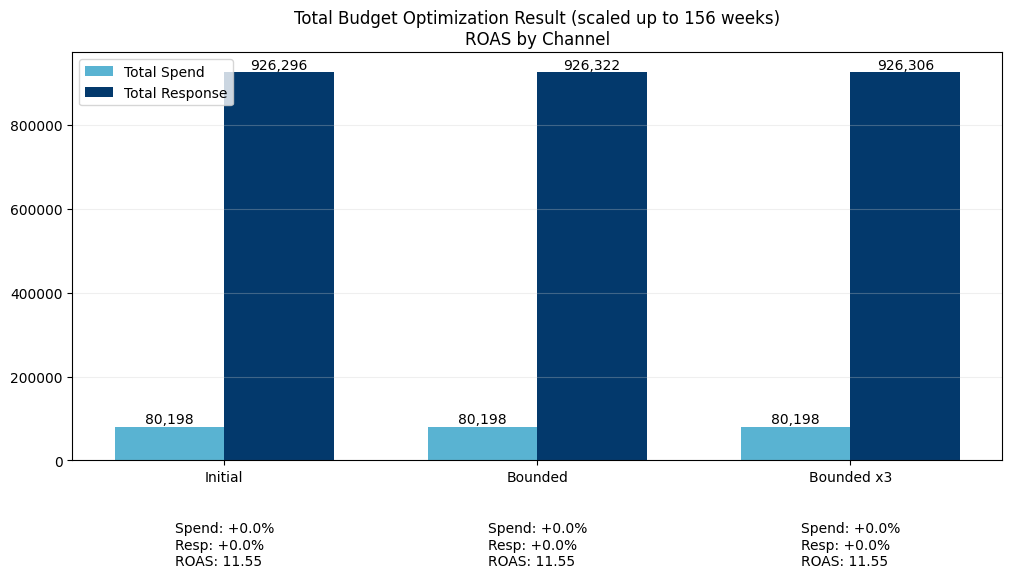

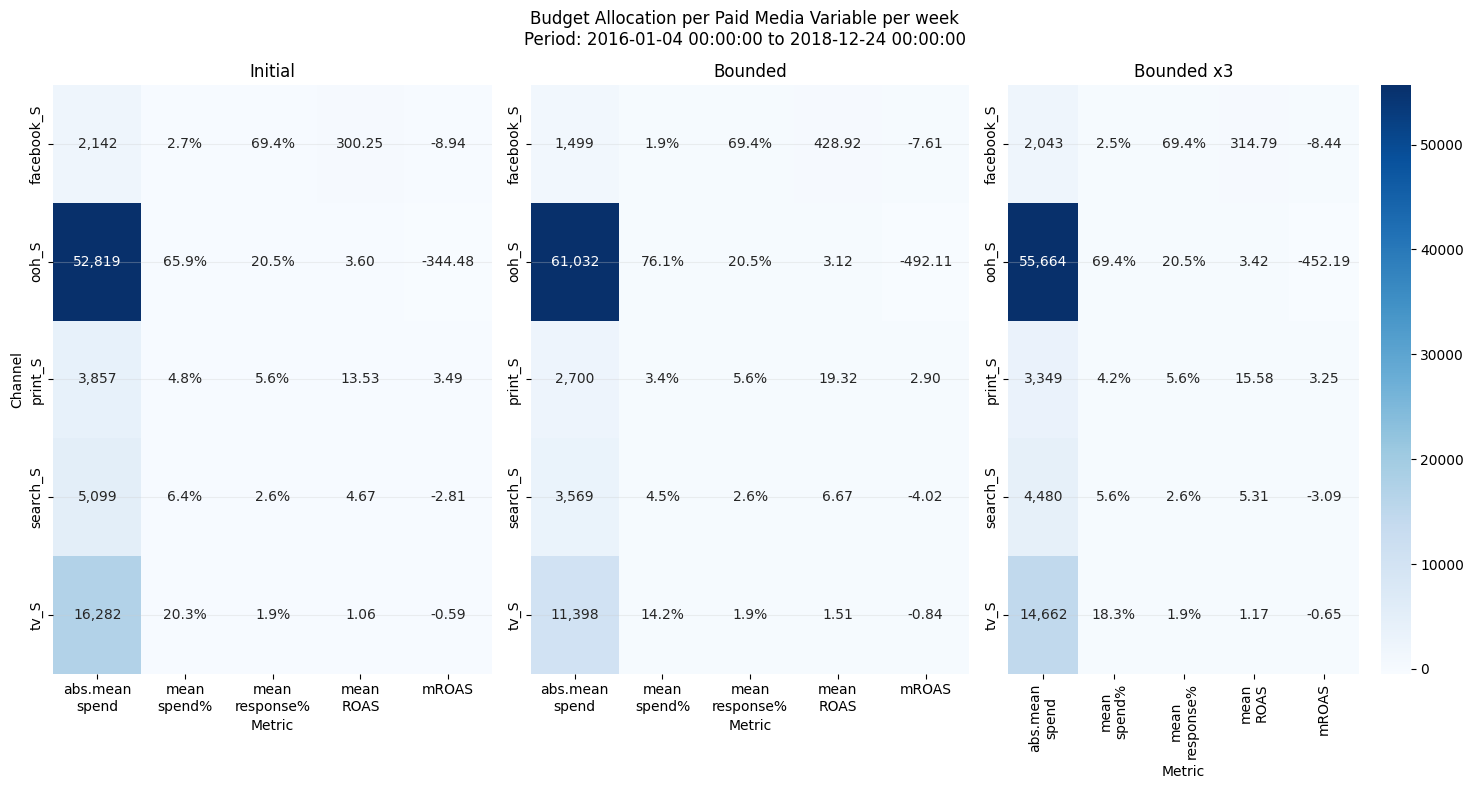

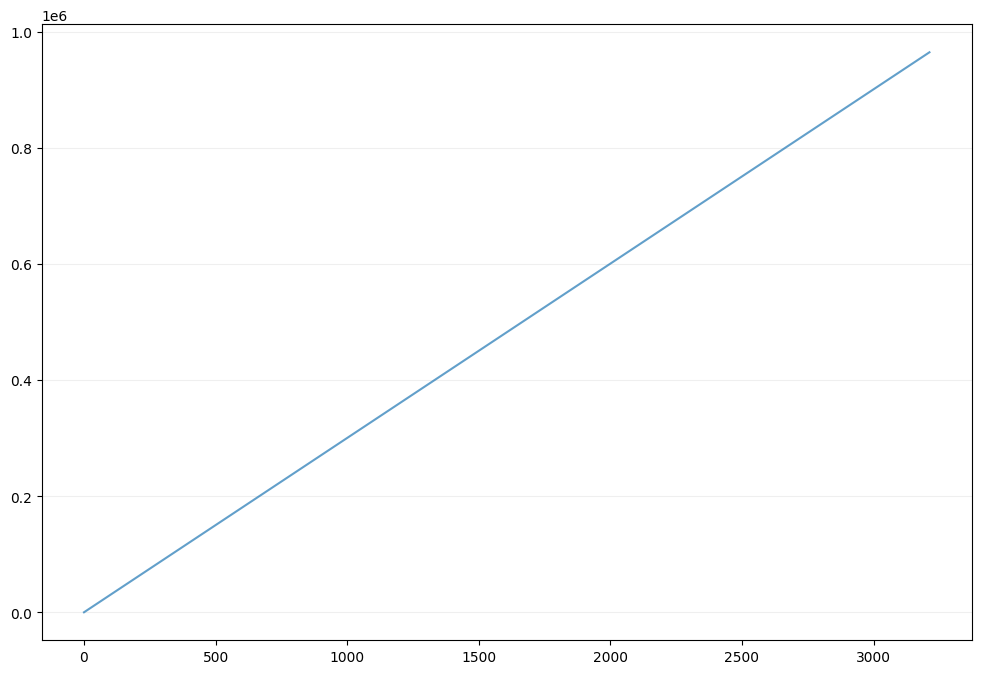

In [11]:
from robyn.allocator_v2.visualization.allocator_plotter import (
    AllocatorPlotter,
    PlotConfig,
)

# After getting allocation results:
plotter = AllocatorPlotter()

config = PlotConfig(
    title=f"Robyn Allocator Results: {select_model}",
    metric="ROAS" if mmm_data.mmmdata_spec.dep_var_type == "revenue" else "CPA",
    interval_type=mmm_data.mmmdata_spec.interval_type,
    model_id=select_model,
    # errors=f"Adj.R2: train = {rsq_train:.4f}, val = {rsq_val:.4f}",
    window_start=allocation_result.dt_optimOut.date_min[0],
    window_end=allocation_result.dt_optimOut.date_max[0],
    scenario=allocation_result.scenario,
)

plots = plotter.create_plots(
    allocation_result=allocation_result,
    config=config,
    export=False,
    # plot_folder="~/Desktop/robyn_plots",
)

# Display plots
for name, fig in plots.items():
    plt.figure(fig.number)
    plt.show()

### Scenario 2: Max Response with Custom Settings

### Scenario 3: Target Efficiency
Optimize allocation based on target ROI/CPA.

### Scenario 4: Custom Target Efficiency